## H&M Personalized Fashion Recommendation 


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import networkx as nx
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.image as mpimg
import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
articles = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/articles.csv")
# customers = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/customers.csv")
transactions = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")

In order to depict this dataset as a Graph, we need to retain only the meaningful rows. The goal is to reduce sparsity as much as possible for better performance.

So, the first thing to do is to calculate the frequency of 'article_id' (product ID) and 'customer_id' (user ID), and consider filtering only users who have many purchase records & products with many purchase records.

In [3]:
item_freq = transactions.groupby('article_id')['customer_id'].nunique()
user_freq = transactions.groupby('customer_id')['article_id'].nunique()

items = item_freq[item_freq >= 100].index
users = user_freq[user_freq >= 100].index

filtered_df = transactions[transactions['article_id'].isin(items) & transactions['customer_id'].isin(users)]

In [4]:
freq = filtered_df.groupby(['customer_id', 'article_id']).size().reset_index(name='frequency')

GraphTravel_HM = filtered_df.merge(freq, on=['customer_id', 'article_id'], how='left')

GraphTravel_HM = GraphTravel_HM[GraphTravel_HM['frequency'] >= 10]

In [5]:
display(GraphTravel_HM)

print("unique customer_id" , GraphTravel_HM.customer_id.nunique())
print("unique article_id" , GraphTravel_HM.article_id.nunique())

,t_dat,customer_id,article_id,price,sales_channel_id,frequency
194,2018-09-20,06636eaa476a2f3417e8d11905e17a8066b4c9ae26bc78...,399201022,0.059305,2,12
195,2018-09-20,06636eaa476a2f3417e8d11905e17a8066b4c9ae26bc78...,399201022,0.059305,2,12
196,2018-09-20,06636eaa476a2f3417e8d11905e17a8066b4c9ae26bc78...,399201022,0.059305,2,12
1181,2018-09-20,1f58e8b3be25c4ca4bb457902f911cfbd4ed3a3f502685...,228257001,0.006763,2,19
1182,2018-09-20,1f58e8b3be25c4ca4bb457902f911cfbd4ed3a3f502685...,228257001,0.006797,2,19
...,...,...,...,...,...,...
6998469,2020-09-22,03fdb0bf2d9ff8ba23e1b4aef53709119aad5bc83691d8...,554450043,0.033881,2,18
6998949,2020-09-22,189a65461f77ed2d1621bb1201e68c4af1cfacf110d08e...,160442010,0.012898,2,11
6998950,2020-09-22,189a65461f77ed2d1621bb1201e68c4af1cfacf110d08e...,160442010,0.012915,2,11
6998951,2020-09-22,189a65461f77ed2d1621bb1201e68c4af1cfacf110d08e...,160442010,0.012898,2,11


unique customer_id 1013
unique article_id 922


/tmp/ipykernel_28/521335795.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(GraphTravel_HM['frequency'], kde=True, bins=30)


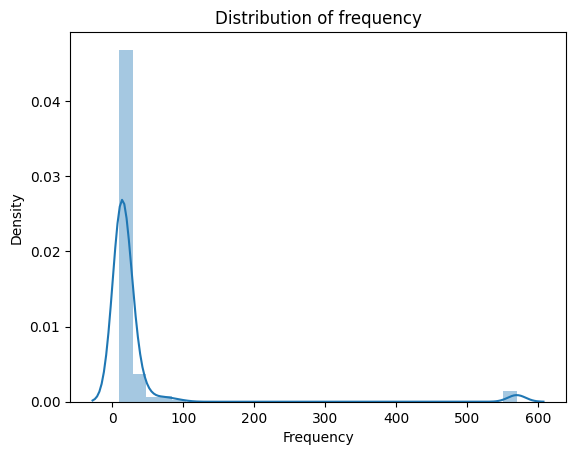

In [6]:
sns.distplot(GraphTravel_HM['frequency'], kde=True, bins=30)

plt.title('Distribution of frequency')
plt.xlabel('Frequency')
plt.ylabel('Density')

plt.show()

Considering we left only the products with more than 10 in the dataframe, the distribution is quite understandable. Most of the repurchase frequencies are concentrated between 10 and 100.

It looks like there's a product that's been purchased as many as 550 times... I wonder what this could be? Although EDA is not important to us right now and Erica will ignore her curiosity, those who are curious might find it fun to check for themselves.

Now, let's move to the final step of preprocessing. The values of customer_id were mixed with integers and strings as hash values, weren't they? I'll map these to integers. If it's an integer starting from 0, it's likely not to overlap with the article_id.

Also, to print the item name along with the recommendation result, I'll create one dictionary as well.

In [7]:
unique_customer_ids = GraphTravel_HM['customer_id'].unique()
customer_id_mapping = {id: i for i, id in enumerate(unique_customer_ids)}
GraphTravel_HM['customer_id'] = GraphTravel_HM['customer_id'].map(customer_id_mapping)

item_name_mapping = dict(zip(articles['article_id'], articles['prod_name'])) # prod_name

In [8]:
# customer_id_mapping

In [9]:
G = nx.Graph()

for index, row in GraphTravel_HM.iterrows():
    G.add_node(row['customer_id'], type='user')
    G.add_node(row['article_id'], type='item')
    G.add_edge(row['customer_id'], row['article_id'], weight=row['frequency'])

In [10]:
# biased random walk  
def biased_random_walk(G, start_node, walk_length, p=1, q=1):
    walk = [start_node]

    while len(walk) < walk_length:
        cur_node = walk[-1]
        cur_neighbors = list(G.neighbors(cur_node))

        if len(cur_neighbors) > 0:
            if len(walk) == 1:
                walk.append(random.choice(cur_neighbors))
            else:
                prev_node = walk[-2]

                probability = []
                for neighbor in cur_neighbors:
                    if neighbor == prev_node:
                        # Return parameter 
                        probability.append(1/p)
                    elif G.has_edge(neighbor, prev_node):
                        # Stay parameter 
                        probability.append(1)
                    else:
                        # In-out parameter 
                        probability.append(1/q)

                probability = np.array(probability)
                probability = probability / probability.sum()  # normalize

                next_node = np.random.choice(cur_neighbors, p=probability)
                walk.append(next_node)
        else:
            break

    return walk

In [11]:
def generate_walks(G, num_walks, walk_length, p=1, q=1):
    walks = []
    nodes = list(G.nodes())
    for _ in range(num_walks):
        random.shuffle(nodes)  # to ensure randomness
        for node in nodes:
            walk_from_node = biased_random_walk(G, node, walk_length, p, q)
            walks.append(walk_from_node)
    return walks

In [12]:
# generate_walks(G, 2, 8, p=0.5, q=0.5)

In [13]:
# Random Walk 
walks = generate_walks(G, num_walks=10, walk_length=20, p=9, q=1)
filtered_walks = [walk for walk in walks if len(walk) >= 5]

# to String  (for Word2Vec input)
walks = [[str(node) for node in walk] for walk in walks]

# Word2Vec train
model = Word2Vec(walks, vector_size=128, window=5, min_count=0,  hs=1, sg=1, workers=4, epochs=10)

# node embedding extract
embeddings = {node_id: model.wv[node_id] for node_id in model.wv.index_to_key}

In [14]:
# embeddings

In [15]:
def get_user_embedding(user_id, embeddings):
    return embeddings[str(user_id)]

In [16]:
def get_rated_items(user_id, df):
    return set(df[df['customer_id'] == user_id]['article_id'])

In [17]:
def calculate_similarities(user_id, df, embeddings):
    rated_items = get_rated_items(user_id, df)
    user_embedding = get_user_embedding(user_id, embeddings)

    item_similarities = []
    for item_id in set(df['article_id']):
        if item_id not in rated_items:  
            item_embedding = embeddings[str(item_id)]
            similarity = cosine_similarity([user_embedding], [item_embedding])[0][0]
            item_similarities.append((item_id, similarity))

    return item_similarities

In [18]:
def show_images(items, item_name_mapping, num_items, show_similarity=False):
    f, ax = plt.subplots(1, num_items, figsize=(20,10))
    if num_items == 1:
        ax = [ax]
    for i, item in enumerate(items):
        item_id, similarity = item
        print(f"- Item {item_id}: {item_name_mapping[item_id]}", end='')
        if show_similarity:
            print(f" with similarity score: {similarity}")
        else:
            print()
        img_path = f"../input/h-and-m-personalized-fashion-recommendations/images/0{str(item_id)[:2]}/0{int(item_id)}.jpg"
        try:
            img = mpimg.imread(img_path)
            ax[i].imshow(img)
            ax[i].set_title(f'Item {item_id}')
            ax[i].set_xticks([], [])
            ax[i].set_yticks([], [])
            ax[i].grid(False)
        except FileNotFoundError:
            print(f"Image for item {item_id} not found.")
    plt.show()

## recommend_items

This function places the functions defined above appropriately, and outputs the final recommendation result. Ultimately, it finds items that are close in Embedding distance based on the user's transaction history, in other words, items the user might like, or in other words, the most similar items, and visually outputs the result.

It means that you can present a recommendation result that can be called personalized recommendation!

In [19]:

def recommend_items(user_id, df, embeddings, item_name_mapping, num_items=5):
    rated_items = get_rated_items(user_id, df)
    
    print(f"User {user_id} has purchased:")
    show_images([(item_id, 0) for item_id in list(rated_items)[:5]], item_name_mapping, min(len(rated_items), 5))
    
    item_similarities = calculate_similarities(user_id, df, embeddings)

    recommended_items = sorted(item_similarities, key=lambda x: x[1], reverse=True)[:num_items]

    print(f"\nRecommended items for user {user_id}:")
    show_images(recommended_items, item_name_mapping, num_items, show_similarity=True)


User 45 has purchased:
- Item 598811011: Dingo tank
- Item 189616006: Heavy jsy long leg
- Item 598517002: SANDY shorts
- Item 633808016: Terrier tee TOP PRODUCT
- Item 443696021: BO basic OH BB


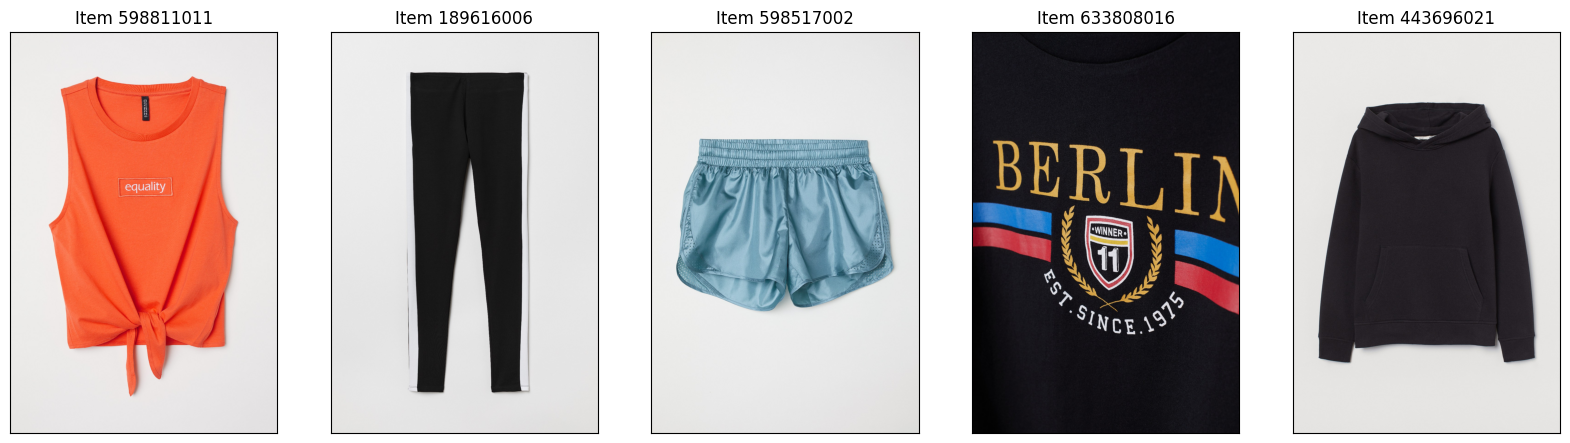


Recommended items for user 45:
- Item 568597022: Hayes slim with similarity score: 0.8128114342689514
- Item 816563002: Drizzle with similarity score: 0.698857843875885
- Item 657283008: LS TANGA TWIST with similarity score: 0.6934126615524292
- Item 403490012: ELIAS basic V-neck BB 2-p with similarity score: 0.6510941982269287
- Item 477107015: Ellen Bikini Clover Mid 3p with similarity score: 0.6353906393051147


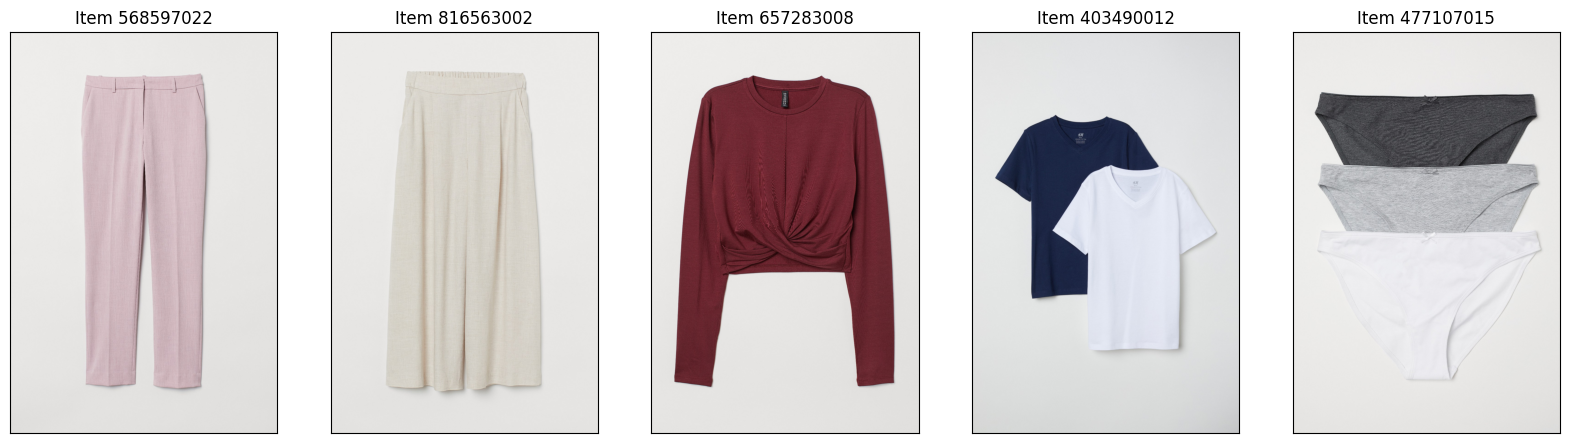

In [20]:
# costomer 45's top 5 
recommend_items(45, GraphTravel_HM, embeddings, item_name_mapping, num_items=5)

### Project mentored by: [KHYJ00](https://www.kaggle.com/khyj00)

